In [1]:
from __future__ import absolute_import, division, print_function

import os
import time
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve, average_precision_score

from Data_helper import LoadDataTrial
from utils.attention_function import attention_3d_block_spatial as PreAttentionSpatial
from BuildModel import LoadModel

%matplotlib inline

Using TensorFlow backend.


In [2]:
arg_parser = argparse.ArgumentParser()
arg_parser.add_argument('--working_path', default='.')

## data
arg_parser.add_argument('--dataset_name', default='phase_viii', 
                         help='The data files should be saved in [working_path]/data/[dataset_name] directory.')
arg_parser.add_argument('--fold', type=int, default=0, 
                         help='the fold data taken to use, there are 5 folds or 10 folds')
arg_parser.add_argument('--label', default=4, type=int, choices=[-1,0,1,2,3,4],
                         help='the label type')

## model
arg_parser.add_argument('--model_type', default='HMM_LF', choices=['LR', 'RF', 'SVM', 'DNN', 'DNN_EE', 'GRUD', 'HMM_EF', 'HMM_LF'])
arg_parser.add_argument('--max_timestep', type=int, default=200, 
                        help='Time series of at most # time steps are used. Default: 200.')
arg_parser.add_argument('--max_timestamp', type=int, default=48*60*60,choices=[48*60*60, 72*60*60, 96*60*60, 120*60*60],
                        help='Time series of at most # seconds are used. Default: 48 (hours).')
arg_parser.add_argument('--use_bidirectional_rnn', default=False)
# Train
arg_parser.add_argument('--trainORvalidation', default='Train', choices=['Train', 'Validation'])
arg_parser.add_argument('--epochs', type=int, default=200)
arg_parser.add_argument('--early_stopping_patience', type=int, default=20)
arg_parser.add_argument('--batch_size', type=int, default=32)
# set the actual arguments if running in notebook
if not (__name__ == '__main__' and '__file__' in globals()):
    ARGS = arg_parser.parse_args([
        '--model_type', 'HMM_LF',
        '--dataset_name', 'phase_viii',
        '--fold', '0',
        '--epochs', '200',
        '--trainORvalidation', 'Train'
    ])
else:
      ARGS = arg_parser.parse_args()

print('Arguments:', ARGS)


Arguments: Namespace(batch_size=32, dataset_name='phase_viii', early_stopping_patience=20, epochs=200, fold=0, label=4, max_timestamp=172800, max_timestep=200, model_type='HMM_LF', trainORvalidation='Train', use_bidirectional_rnn=False, working_path='.')


In [3]:
# define the label, -1 represent the multi-class classification
model_path = os.path.join(ARGS.working_path, 'model_tuning', 'phase_viii', '48hours', '20220604', 'HMMLF_CONCAT_423dim_48hrs_Paper(last)')
if not os.path.exists(model_path):
    os.makedirs(model_path)
output_path = os.path.join(ARGS.working_path, 'test', 'phase_viii', '48hours', '20220604', 'Interpretability')
if not os.path.exists(output_path):
    os.makedirs(output_path)
dict_path = os.path.join(ARGS.working_path, 'data', 'phase_viii', '48hours')
if not os.path.exists(dict_path):
    os.makedirs(dict_path)

T = time.strftime("%Y%m%d%H%M%S", time.localtime())
LABEL_DICT = {'-1': 'flatten multi-classification', 
              '0': 'infectious and non-infectious', 
              '1': 'bacterial, viral and others', 
              '2': 'NIID and tumor', 
              '3': 'AD and AID', 
              '4': 'HM and SM'}
dataset = LoadDataTrial(data_path=os.path.join('.', 'data', ARGS.dataset_name, '48hours', 'processed', 'raw/data4hc_v20220401'), 
                            model_type=ARGS.model_type,
                            label_name=ARGS.label,
                            max_timestep=ARGS.max_timestep,
                            max_timestamp=ARGS.max_timestamp)
X_train, y_train_1d, nclasses_train, folds_train, shapes_train = dataset.training_generator(ARGS.fold)
X_validation, y_validation_1d, nclasses_validation,folds_validation, shapes_validation = dataset.validation_generator(ARGS.fold)
X_test, y_test_1d, nclasses_test, folds_test, shapes_test = dataset.test_generator(ARGS.fold)

y_train = to_categorical(y_train_1d, num_classes=nclasses_train)           
y_validation = to_categorical(y_validation_1d, num_classes=nclasses_train)
y_test = to_categorical(y_test_1d, num_classes=nclasses_train)

# get the boolmatrix
boolmat = X_test[1].astype(np.bool)

# DEFINE THE FEATURE LIST
features = ['Temporature', 'Respiratory Rate', 'Pulse Rate', 'DBP', 'SBP', 'SPO2', 'Time']

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [4]:
''' this function is adapted from Keras documentation '''

def get_activations(model, inputs, print_shape_only=False, layer_name=None, verbose=False):
  
    """
    Get activations from a model
    Args:
        model: a keras model
        inputs: the inputs for the model
        print_shape_only: whether to print the shape of the layer or the whole activation layer
        layer_name: name of specific layer to return
        verbose: whether to show all outputs
    Returns:
        activations: list, list of activations
    """
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if verbose:
            print('----- activations -----')
            if print_shape_only:
                print(layer_activations.shape)
            else:
                print(layer_activations)
    return activations

def normalize_activations(activations_matrix):
    means = np.nanmean(activations_matrix, axis=0)
    stds = np.nanstd(activations_matrix, axis=0)
    return (activations_matrix - means) / stds

In [5]:
# load the model
model = LoadModel(os.path.join(model_path, 'HMMLF({0}).h5'.format(LABEL_DICT[str(ARGS.label)])))

# GET ACTIVATIONS MATRX, OUTPUT IS (BATCH_SIZE, TIME_STEPS, FEATURES)
activations = get_activations(model, X_test, print_shape_only=True, layer_name='attention_vec')[0]

 # MASK THE MISSING VALUE CORRESPONDING ATTRIBUTIONS
activations[~boolmat] = np.nan

# AVERAGE ATTENTION VECTOR ACROSS SAMPLES ; OUTPUT IS 2D TIME_STEPS X FEATURES
attention_matrix = np.nanmean(activations, axis=0)

# AVERAGE THE ATTENTION MATRIX OVER FEATURES ; OUTPUT IS 1D FEATURES
attention_vector = np.nanmean(attention_matrix, axis=0)

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [7]:
# infectious and Noninfectious
dict_infec = {'feature': features,
              'attention': [0.10334655, 0.059641, 0.34834522, 0.10750608, 0.1044924, 0.09547549, 0.07198162]}
df_infec = pd.DataFrame(dict_infec).set_index(['feature'])
df_infec = df_infec.iloc[df_infec['attention'].argsort()[::-1]]

# Bacterial, viral and fungal
dict_bac = {'feature': features,
            'attention': [0.05259341, 0.15732607, 0.19323464, 0.11537954, 0.09642897, 0.08665615, 0.29150954]}
df_bac = pd.DataFrame(dict_bac).set_index(['feature'])
df_bac = df_bac.iloc[df_bac['attention'].argsort()[::-1]]

# NIID and Neo
dict_niid = {'feature': features,
            'attention': [0.10230719, 0.57931566, 0.04865059, 0.19153465, 0.10178633, 0.08155458, 0.08179213]}
df_niid = pd.DataFrame(dict_niid).set_index(['feature'])
df_niid = df_niid.iloc[df_niid['attention'].argsort()[::-1]]

# AID and AIFD
dict_aid = {'feature': features,
            'attention': [0.02654325, 0.03397344, 0.64908415, 0.07962078, 0.10734562, 0.18705072, 0.026084]}
df_aid = pd.DataFrame(dict_aid).set_index(['feature'])
df_aid = df_aid.iloc[df_aid['attention'].argsort()[::-1]]

# HM and SM
dict_hm = {'feature': features,
            'attention': [0.02580769, 0.04276748, 0.02063744, 0.4180476, 0.0889037, 0.4094223 , 0.1070873]}
df_hm = pd.DataFrame(dict_hm).set_index(['feature'])
df_hm = df_hm.iloc[df_hm['attention'].argsort()[::-1]]

/home/zju/anaconda3/envs/gru/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


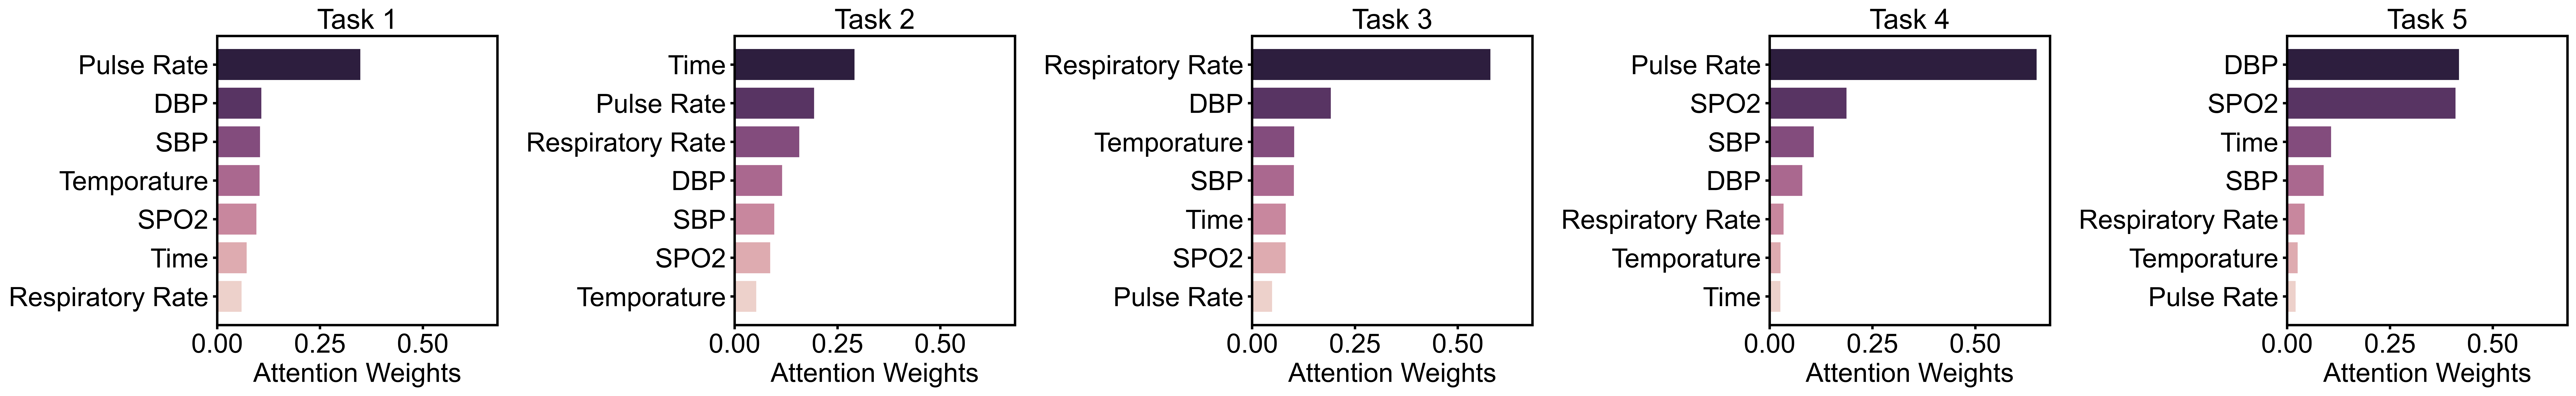

In [15]:
from matplotlib import gridspec
plt.rc('font',family='Arial', size=22)

color_list = sns.cubehelix_palette(7)

fig, axes = plt.subplots(1, 5, figsize=(30,5), dpi=600, constrained_layout=True, sharex='row')

# infec
x = df_infec.index.tolist()
y = df_infec['attention'].values
color_rank = np.argsort(np.argsort(y))

axes[0].barh(x, y, color=np.array(color_list)[color_rank])
axes[0].set_title('Task 1', fontproperties="Arial", fontsize=23)
axes[0].spines['right'].set_linewidth(2)
axes[0].spines['top'].set_linewidth(2)
axes[0].spines['left'].set_linewidth(2)
axes[0].spines['bottom'].set_linewidth(2)
axes[0].tick_params(width=2)
axes[0].set_xlabel('Attention Weights', fontproperties="Arial", fontsize=22)
axes[0].invert_yaxis()

# Bacterial
x = df_bac.index.tolist()
y = df_bac['attention'].values
color_rank = np.argsort(np.argsort(y))

axes[1].barh(x, y, color=np.array(color_list)[color_rank])
axes[1].set_title('Task 2', fontproperties="Arial", fontsize=23)
axes[1].spines['right'].set_linewidth(2)
axes[1].spines['top'].set_linewidth(2)
axes[1].spines['left'].set_linewidth(2)
axes[1].spines['bottom'].set_linewidth(2)
axes[1].tick_params(width=2)
axes[1].set_xlabel('Attention Weights', fontproperties="Arial", fontsize=22)
axes[1].invert_yaxis()

# NIID
x = df_niid.index.tolist()
y = df_niid['attention'].values
color_rank = np.argsort(np.argsort(y))

axes[2].barh(x, y, color=np.array(color_list)[color_rank])
axes[2].set_title('Task 3', fontproperties="Arial", fontsize=23)
axes[2].spines['right'].set_linewidth(2)
axes[2].spines['top'].set_linewidth(2)
axes[2].spines['left'].set_linewidth(2)
axes[2].spines['bottom'].set_linewidth(2)
axes[2].tick_params(width=2)
axes[2].set_xlabel('Attention Weights', fontproperties="Arial", fontsize=22)
axes[2].invert_yaxis()

# AID
x = df_aid.index.tolist()
y = df_aid['attention'].values
color_rank = np.argsort(np.argsort(y))

axes[3].barh(x, y, color=np.array(color_list)[color_rank])
axes[3].set_title('Task 4', fontproperties="Arial", fontsize=23)
axes[3].spines['right'].set_linewidth(2)
axes[3].spines['top'].set_linewidth(2)
axes[3].spines['left'].set_linewidth(2)
axes[3].spines['bottom'].set_linewidth(2)
axes[3].tick_params(width=2)
axes[3].set_xlabel('Attention Weights', fontproperties="Arial", fontsize=22)
axes[3].invert_yaxis()

# HM
x = df_hm.index.tolist()
y = df_hm['attention'].values
color_rank = np.argsort(np.argsort(y))

axes[4].barh(x, y, color=np.array(color_list)[color_rank])
axes[4].set_title('Task 5', fontproperties="Arial", fontsize=23)
axes[4].spines['right'].set_linewidth(2)
axes[4].spines['top'].set_linewidth(2)
axes[4].spines['left'].set_linewidth(2)
axes[4].spines['bottom'].set_linewidth(2)
axes[4].tick_params(width=2)
axes[4].set_xlabel('Attention Weights', fontproperties="Arial", fontsize=22)
axes[4].invert_yaxis()

plt.tight_layout() 
plt.savefig(os.path.join(output_path, 'Fig6_Interpretability_Attention_English.png'), dpi=600, bbox_inches='tight')